<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Будем обращаться к линукс-ядру напрямую с помощью команд на "!"
# Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)
# Код, представленный в документации разработчика
!apt install swig cmake libopenmpi-dev zlib1g-dev # cmake - сборка - аналог GNU Make, но с другим синтаксисом, libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!pip install stable-baselines==2.5.1 box2d box2d-kengz # устанавливаем непосредственно сам stable baseline и движок box2d

# если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # установка пакета для рендера видео
!pip install xvfbwrapper # установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба  
!apt-get update # обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!sudo apt-get install xvfb # установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!apt-get install xdpyinfo # пакет для вывода процессов, происходящих на сервере

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,153 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 148492 files and dire

In [2]:
import gym # здесь лежат все модели для 
from gym import logger as gymlogger # загрузим библиотеку для изменения параметра вывода ошибок
from gym.wrappers import Monitor # библиотека для обертки видео из хранилища в ячейку
gymlogger.set_level(40) # для правильного отображения ошибок
import numpy as np # библиотека массивов numpy
import random # библиотека для генерации случайных значений
import matplotlib # библиотека для визуализации процессов
import matplotlib.pyplot as plt # библиотека для построения графика
%matplotlib inline
import glob # расширение для использования Unix обозначений при задании пути к файлу
import io # библиотека для работы с потоковыми данными
import base64 # расширение для преобразования в формат base64 (универсальный формат хранения сырых изображений в виде набора электрических сигналов)
from IPython.display import HTML # библиотека для кодирования в код HTML
import time # библиотека для расчета времени обучения

from IPython import display as ipythondisplay # для работы с "сырым" форматом (набор сигналов, а не пиксели)
from pyvirtualdisplay import Display # для создания окна дисплея


In [3]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

#BipedalWalker

Награда дается за продвижение вперед, всего 300+ очков до дальнего конца. Если робот падает, он получает -100. Применение крутящего момента двигателя стоит небольшого количества баллов, более оптимальный агент получит лучший результат. Состояние состоит из угловой скорости корпуса, угловой скорости, горизонтальной скорости, вертикальной скорости, положения суставов и угловой скорости суставов, контакта ног с землей и 10 измерений лидарного дальномера. Нет координат в векторе состояния.

##Пространство действия

BipedalWalker имеет 2 ноги. Каждая нога имеет 2 сустава. Вы должны научить ходунка двуногих, применяя крутящий момент на этих суставах. Поэтому размер нашего пространства действия составляет 4, то есть крутящий момент, приложенный к 4 суставам. Вы можете применить крутящий момент в диапазоне (-1, 1)

## Награды

Агент получает положительное вознаграждение, пропорциональное пройденному пути на местности. Он может получить в общей сложности 300+ наград до самого конца.  
Если агент падает, он получает вознаграждение -100.  
Существует некоторое отрицательное вознаграждение, пропорциональное крутящему моменту, приложенному к суставу. Так что агент учится ходить плавно с минимальным крутящим моментом.

In [4]:
'''

Функция, позволяющая записывать видео того,
что происходит в окружении и отображать это в колабе

'''

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
# Запускаем среду
env = gym.make('BipedalWalker-v3')

In [6]:
from numpy.random import default_rng
rg = default_rng(2)

size = (24,4)


In [7]:
numBots = 100
popul = [] # здесь будет лежать популяция

for i in range(numBots):  
    rand_arr = rg.random(size)
    rand_signs = rg.choice([-1,1], size)

    bot = rand_arr * rand_signs
#   bot = np.random.random((8,4))
    popul.append(bot)

In [8]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = [0, 0, 0, 0]
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[np.random.randint(0, numBots-1)])
    # action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [9]:
'''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        reverse
        ):
    newpopul = [] # Двумерный массив для новой популяции

    sval= sorted(val, reverse=reverse) # Сортируем зачения в val в зависимости от параметра reverse
    for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
        index = val.index(sval[i]) # Получаем индекс i-того элемента sval в исходном массиве val
        newpopul.append(popul[index]) # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом
    return newpopul, sval # Возвращаем новую популяцию (из nsurv элементов) и сортированный список

'''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = random.randint(0, nsurv - 1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0, nsurv - 1) # Случайный индекс второго родителя в диапазоне от 0 до nsurv - 1    
    botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
    botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2 
   
    return botp1,botp2 # Возвращаем обоих полученных ботов

'''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - j - номер компонента бота
'''

def crossPointFrom2Parents(
        botp1,
        botp2, 
        j
        ):
    pindex = np.random.random() # Получаем случайное число в диапазоне от 0 до 1
    
     #Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
    if pindex < 0.5:
        x = botp1[j]
    else:
        x = botp2[j]
    return x # Возвращаем значние бота

    

'''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
'''

def countValue(
    popul
    ):
  
  action=[0,0,0,0]

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  for bot in popul: # проходимся по каждому боту в популяции
    # env.seed(0)  # При инициализации среда генерируется случайным образом каждый раз новая,
                 # поэтому ограничим интервал генерации - т.е. будем использовать только одну конкретную среду
    env.reset() # И обновлять окружение
    i=0 
    tmp=0
    done=False
    while done!=True:
      observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
      result = np.dot(observation,bot) # матрично перемножаем бота и вектор наблюдения для предсказания следующего движения
      action = result
    #   action = np.argmax(result) # максимальный аргумент - наше движение
      tmp+=reward
    reward_list.append(tmp) # Функция, по которой будет вычисляться "успех текущей симуляции"
    
  return reward_list  

0 19.95243501663208   [-72.39162540658452, -94.24634308408044, -99.18803234799987]
1 19.251924753189087   [-92.76219408706069, -94.880800654643, -96.34999483494829]
2 15.302781820297241   [-70.26651248098031, -92.39261114901738, -97.51721589742745]
3 9.662373304367065   [-59.38366068608643, -91.28214469372651, -97.60897475685289]
4 13.4509859085083   [-42.86814305228741, -93.65959966367362, -96.68225341536912]
5 12.628629446029663   [-38.19171814014064, -85.11284185355055, -86.12461546179337]
6 12.22935962677002   [-71.25299943181808, -78.89034945484421, -83.33163733134914]
7 13.190964698791504   [-51.662778145425484, -61.08344045480509, -65.92145371358923]
8 27.042705059051514   [-60.520114880371935, -67.56369607647589, -68.05659523204314]
9 33.96602702140808   [2.455194203546691, -34.365480451218865, -63.06510593850648]
10 43.043553590774536   [-57.48791462407512, -62.488352878893195, -68.31148840796355]
11 46.940226793289185   [11.590123579598414, -38.74699757272853, -47.82553463209

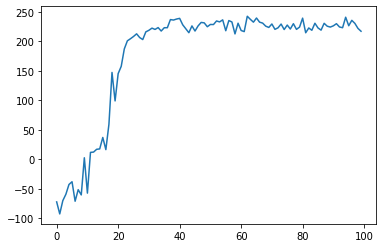

In [10]:
total=[] # Для построения графика
n = 100 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 100 # количество эпох
mut = 0.5 # коэфициент мутаций
curr_time = time.time()
start_mut_count = 4
flag_mut = True

for it in range(epohs): # создали список списков всех значений по эпохам
  val = countValue(popul) # считаем успех каждого из ботов
  newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
  print(it, time.time() - curr_time, " ", sval[0:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
  total.append(sval[0]) # заносим самого лучшего бота в список для построения графика эволюции
  curr_time = time.time() # Обновляем текущее время

  # проходимся по новой популяции
  for k in range(nnew):

    # вытаскиваем новых родителей
    botp1, botp2 = getParents(newpopul, nsurv) 
    newbot = [] # здесь будет новый бот

    for j in range(len(botp1)): # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
      x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
    #   if k != 0 and k % 25 == 0 and flag_mut and start_mut_count != 1:
    #       n = start_mut_count / 2
      for t in range(4):
        if it <= 10:
            if random.random()<mut:
                x[t] += random.random()*1e-2
        elif it > 30 and it <= 70:
             if random.random()<mut:
                x[t] += random.random()*1e-3
        else:
            if random.random()<mut:
                x[t] += random.random()*1e-4
      newbot.append(x) # закидываем элемент в бота
    newpopul.append(newbot) # добавляем бота
  popul = newpopul # вывести список на эпоху
  popul = np.array(popul) # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
plt.plot(total)
print(np.mean(total)) 

In [13]:
val = countValue(popul) # считаем успех каждого из ботов
newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1

In [14]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = [0,0,0,0]
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    action = np.dot(observation,newpopul[1])
    # action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()